# Gray Cifar MWTA

## Intro
* **Date**: 1/7/2020
* **What**: Basically just training a mwta network on gray-scale images of cifar10.  Nothing new in terms of algorithms, I just really want to see what the network learns.
* **Why**: I really, *really* want to see the types of features that the mwta layer learns for different numbers of winners.  It should hopefully be deeply, *deeply* dope.
* **Hopes**: I want to see things like Gabor filters.  I very much did *not* see that the last time I trained a sparse network on Gabor filters, but back then I was using a Foldiak-type network, and we know how garbage that network is.
* **Limitations**: I don't really know.  My features can't really have negative values, so I don't think we can get anything that's actually Gabor like.  It'll be interesting to see what it gets though.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import cifar10
from tqdm import tqdm

(x_tr, _), _ = cifar10.load_data()

sl = 32

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="gray", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [2]:
gray_x = np.linalg.norm(x_tr, axis=1)

gp_gray = cp.asarray(gray_x)

In [3]:
gray_x.shape

(50000, 32, 32)

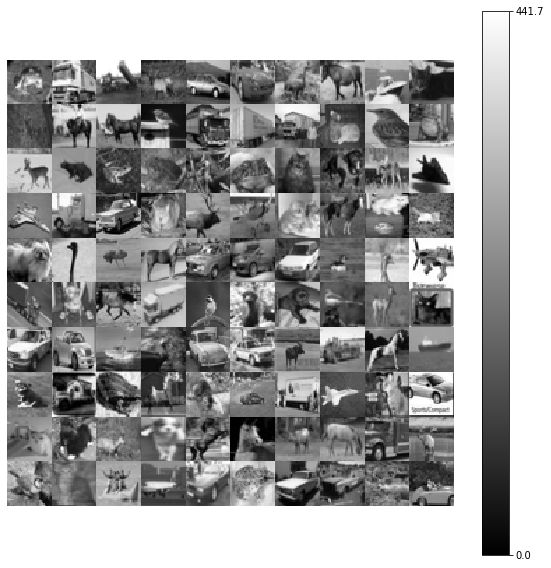

In [7]:
fig = plt.figure(figsize=(10, 10))

draw_weights(gray_x, 10, 10, 32, fig)

## Analysis Dialog

Ok, fam.  Time to train a *beefy* sparse layer on this bad boi.

<IPython.core.display.Javascript object>


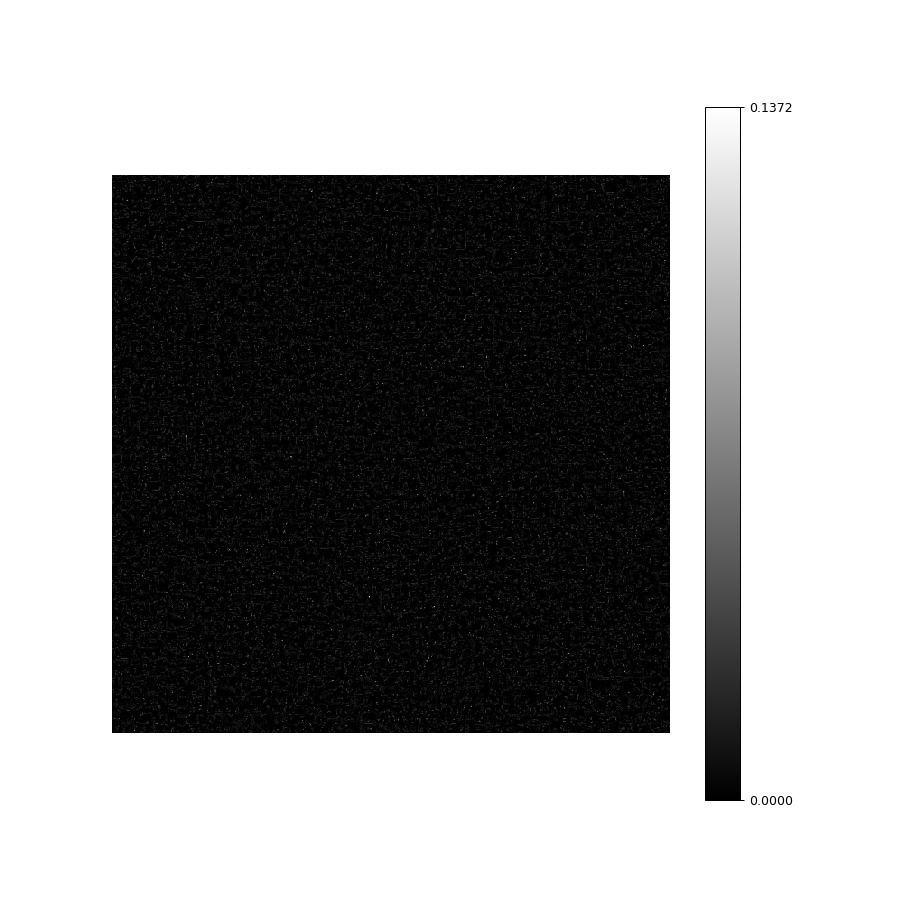

100%|██████████| 5000/5000 [00:05<00:00, 959.51it/s]


In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 5000
prec = 1e-10

# Sparse Layer
Kx = 60
Ky = 60
sN = Kx * Ky
m_len = sl ** 2

n_w = 50 #Number of winners

sw = cp.random.uniform(0, 0.01, (sN, m_len))
xi = 0.0001

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


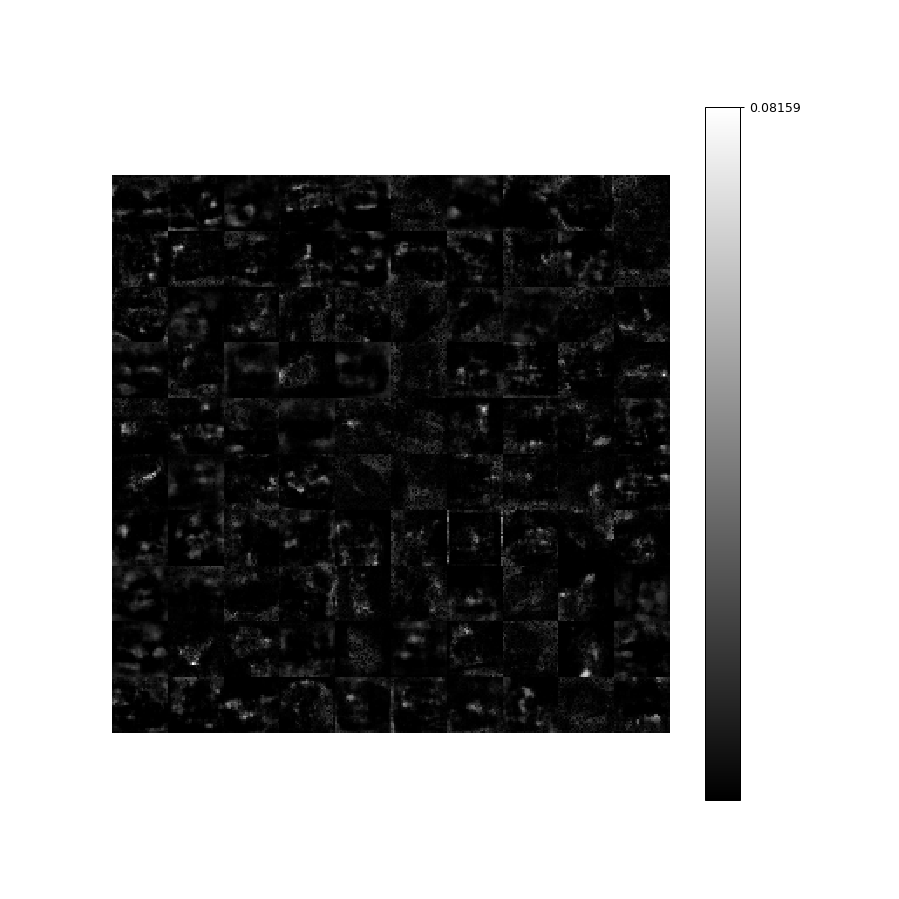

In [9]:
fig = plt.figure(figsize=(10, 10))

draw_weights(sw.get(), 10, 10, sl, fig)

Yikes.  Let's train that on bigger epochs.

<IPython.core.display.Javascript object>


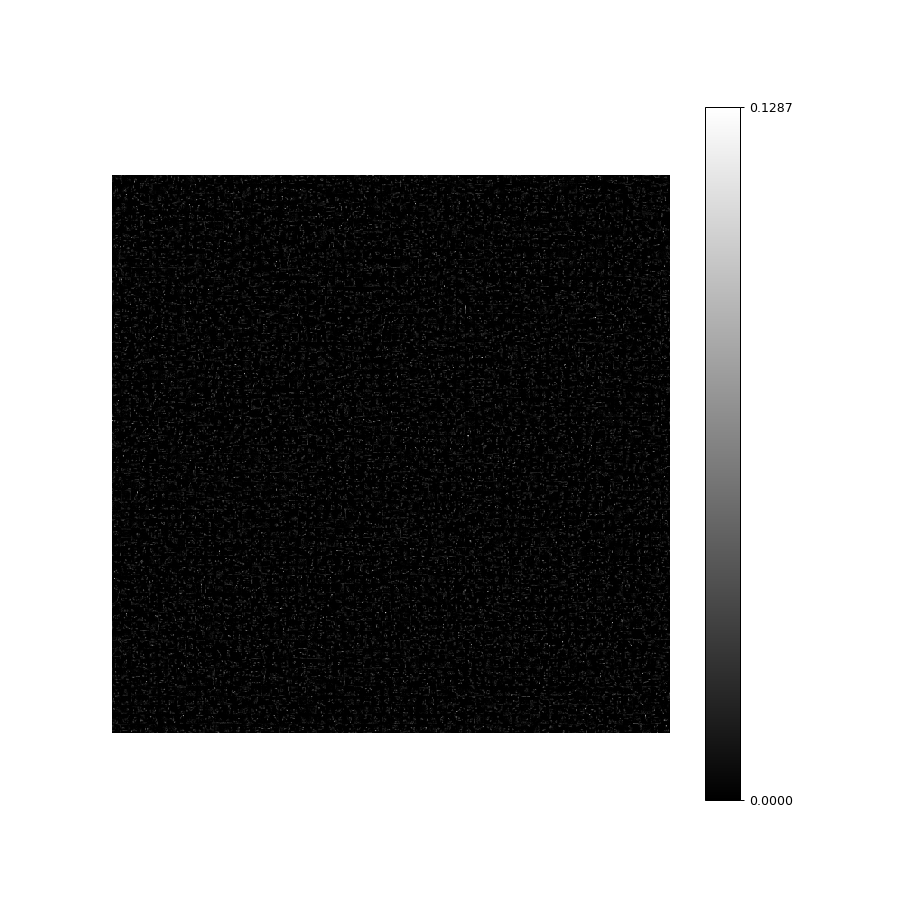

100%|██████████| 50000/50000 [00:52<00:00, 960.61it/s]


In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 50000
prec = 1e-10

# Sparse Layer
Kx = 60
Ky = 60
sN = Kx * Ky
m_len = sl ** 2

n_w = 50 #Number of winners

sw = cp.random.uniform(0, 0.01, (sN, m_len))
xi = 0.0001

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


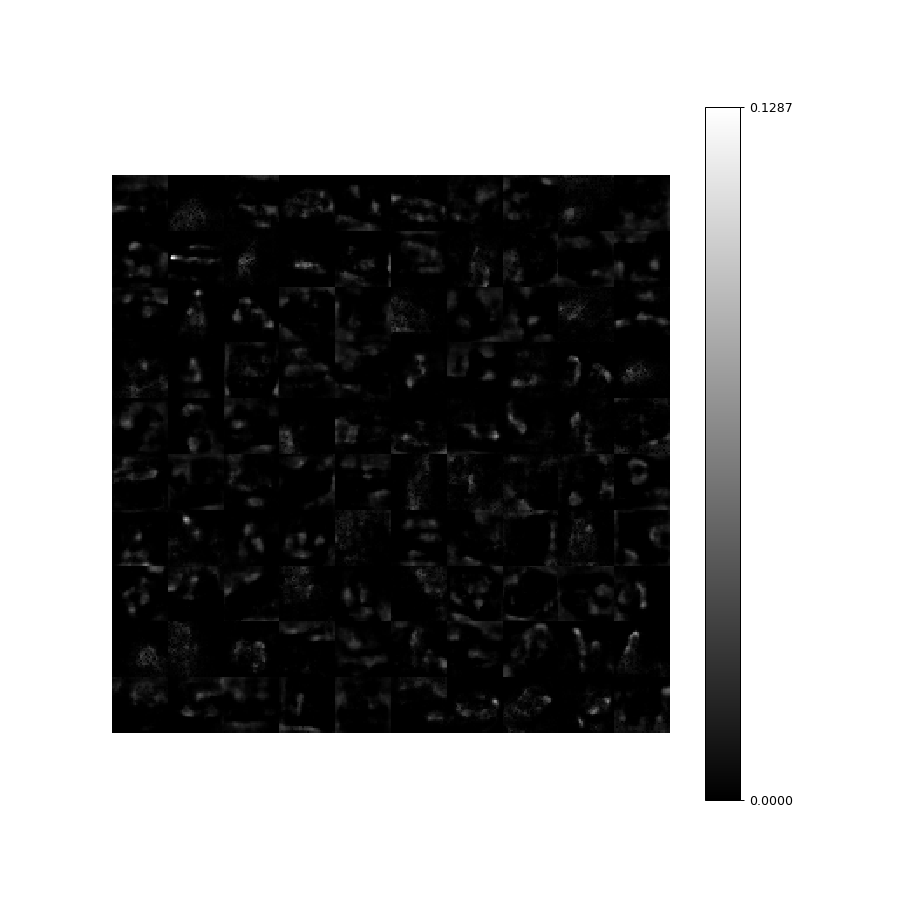

In [12]:
fig = plt.figure(figsize=(10, 10))

draw_weights(sw.get()[100:], 10, 10, sl, fig)

Interesting.  Let's plot the reconstructions.

<IPython.core.display.Javascript object>


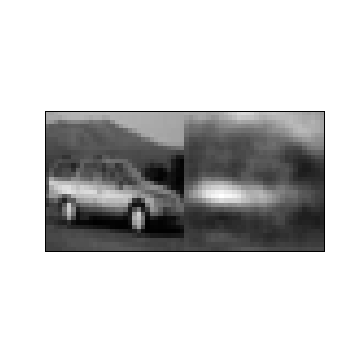

In [20]:
plt.figure(figsize=(4, 4))

img_i = 4

v = gp_gray[img_i].reshape(-1, 1)
p = sw @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p
r = sw.T @ so_uw

vr = np.zeros((32, 64))
vr[:, :32] = v.reshape(32, 32).get()
vr[:, -32:] = r.reshape(32, 32).get()

plt.xticks([])
plt.yticks([])
plt.imshow(vr, cmap="gray")
plt.show()

Good heavens.  It's only able to capture the basic gist of a image.  Time to bump the number of winners right up to 100.

<IPython.core.display.Javascript object>


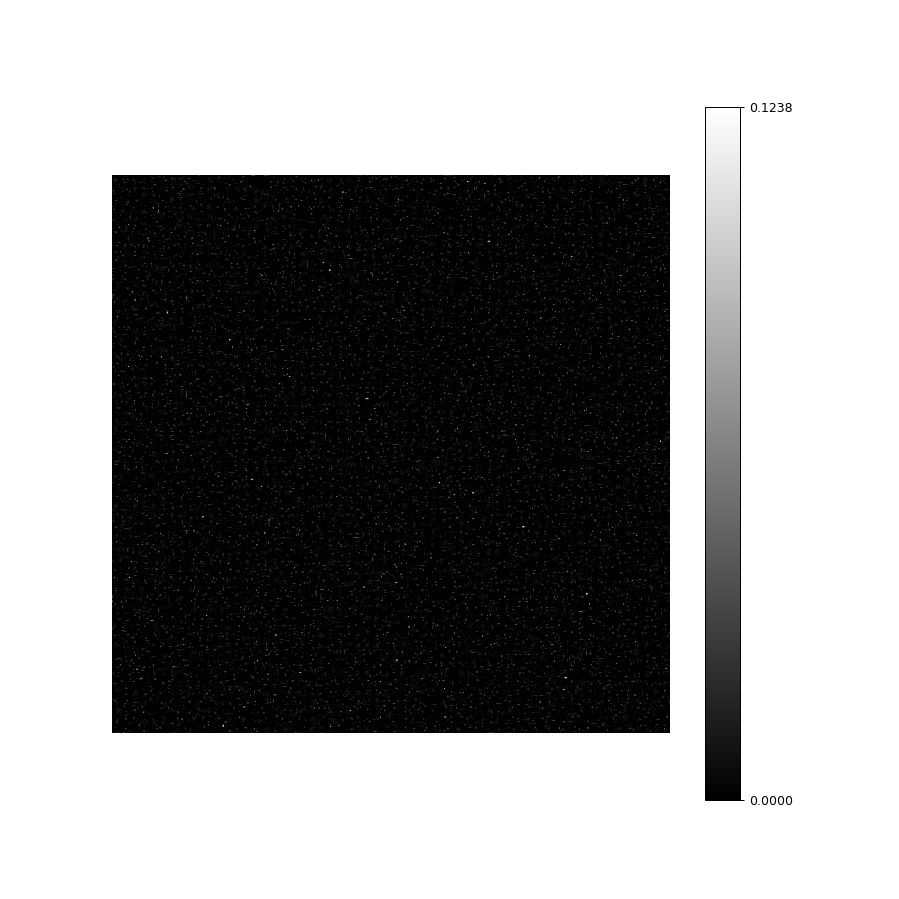

100%|██████████| 50000/50000 [00:51<00:00, 962.69it/s]


In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 50000
prec = 1e-10

# Sparse Layer
Kx = 60
Ky = 60
sN = Kx * Ky
m_len = sl ** 2

n_w = 100 #Number of winners

sw = cp.random.uniform(0, 0.01, (sN, m_len))
xi = 0.0001

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


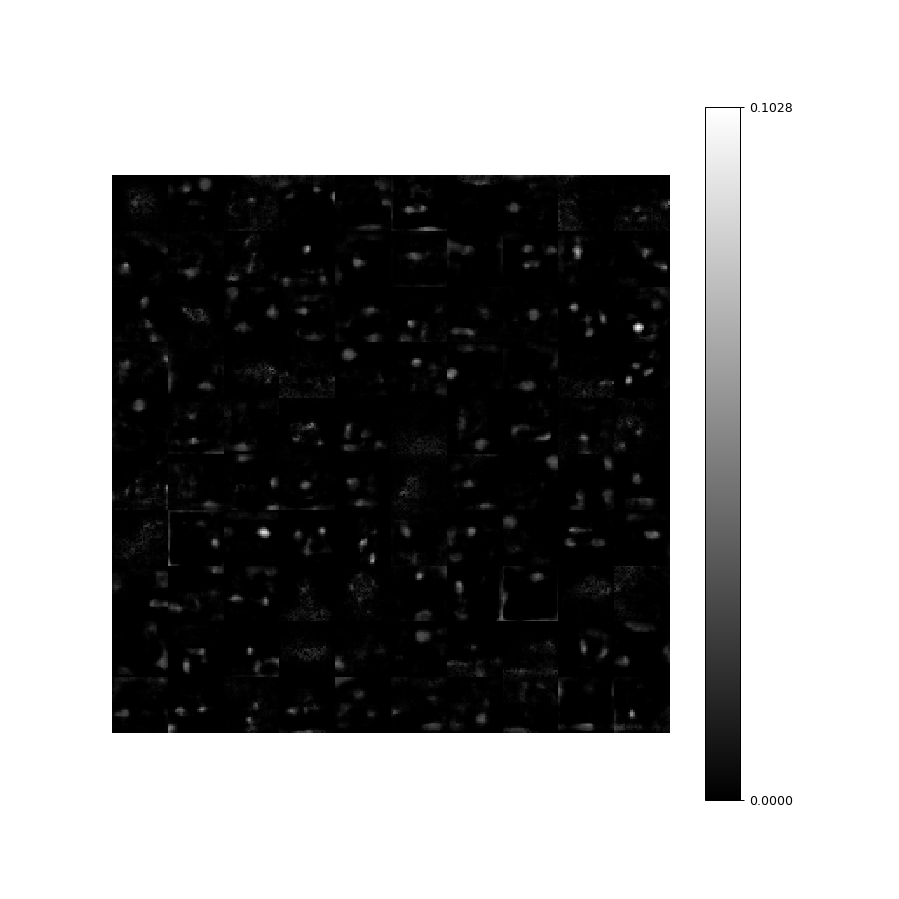

In [25]:
fig = plt.figure(figsize=(10, 10))

draw_weights(sw.get()[500:], 10, 10, sl, fig)

Well, one thing that's absolutely fascinating is that very often, it seems as though the network is learning features that are a triangle of dots.  I mean, they're almost kinda oriented.  It's certainly not gabor, but it almost looks like spherical harmonics.  Holy shit.  Ok, I think I might actually really benefit from whitening the images (not that I really even know what that means, but first I'm going to just train this network for 10 minutes, and see what it comes up with.

Oh, but first, reconstructions.

<IPython.core.display.Javascript object>


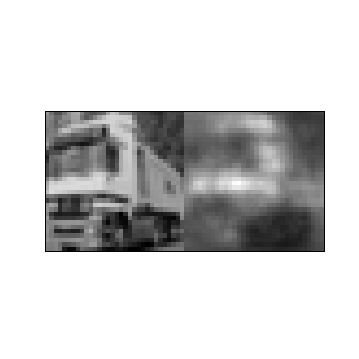

<IPython.core.display.Javascript object>


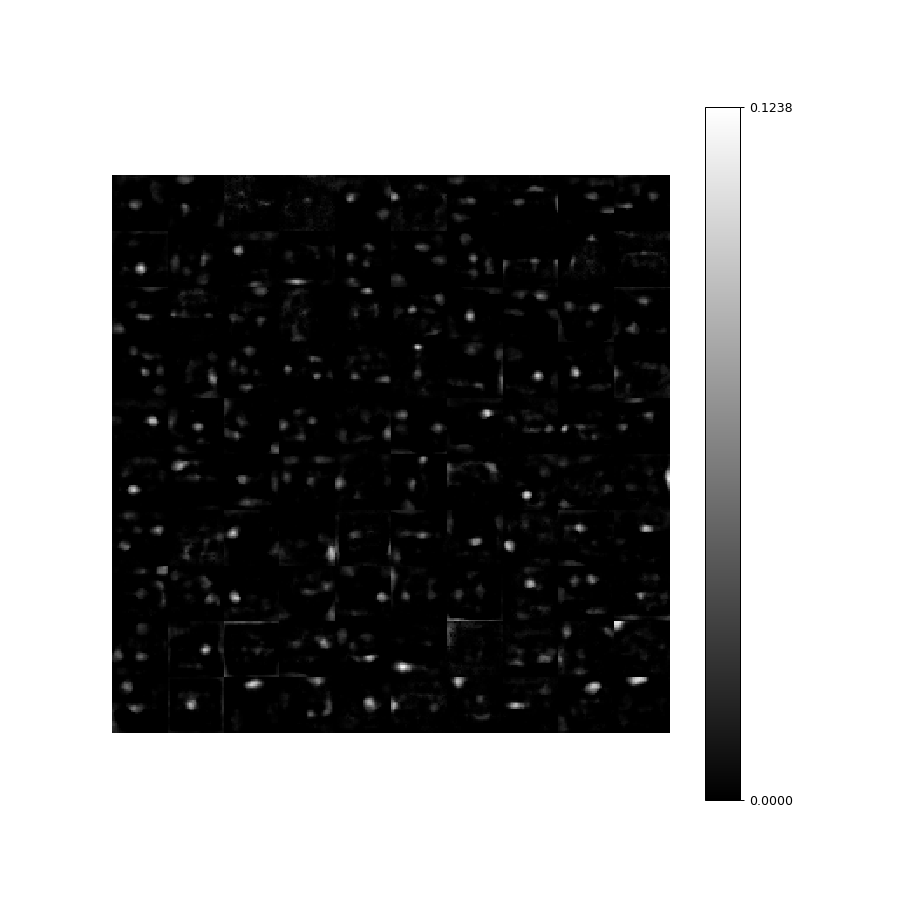

In [36]:
plt.figure(figsize=(4, 4))

img_i = 1

v = gp_gray[img_i].reshape(-1, 1)
p = sw @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p
r = sw.T @ so_uw

vr = np.zeros((32, 64))
vr[:, :32] = v.reshape(32, 32).get()
vr[:, -32:] = r.reshape(32, 32).get()

plt.xticks([])
plt.yticks([])
plt.imshow(vr, cmap="gray")
plt.show()

fig = plt.figure(figsize=(10, 10))

draw_weights(sw[winners].get(), 10, 10, sl, fig)

Yeah, the reconstructions still aren't that great.  But still, it's kinda crazy how much it looks like additions of spherical harmonics.  I guess in 2d, but still, maybe they're representations of the SO(2) group?  I can't exactly remember how that goes.  

Ok, I'm going to train with 200 winners now.  Hopefully we see some super interesting basis functions.

<IPython.core.display.Javascript object>


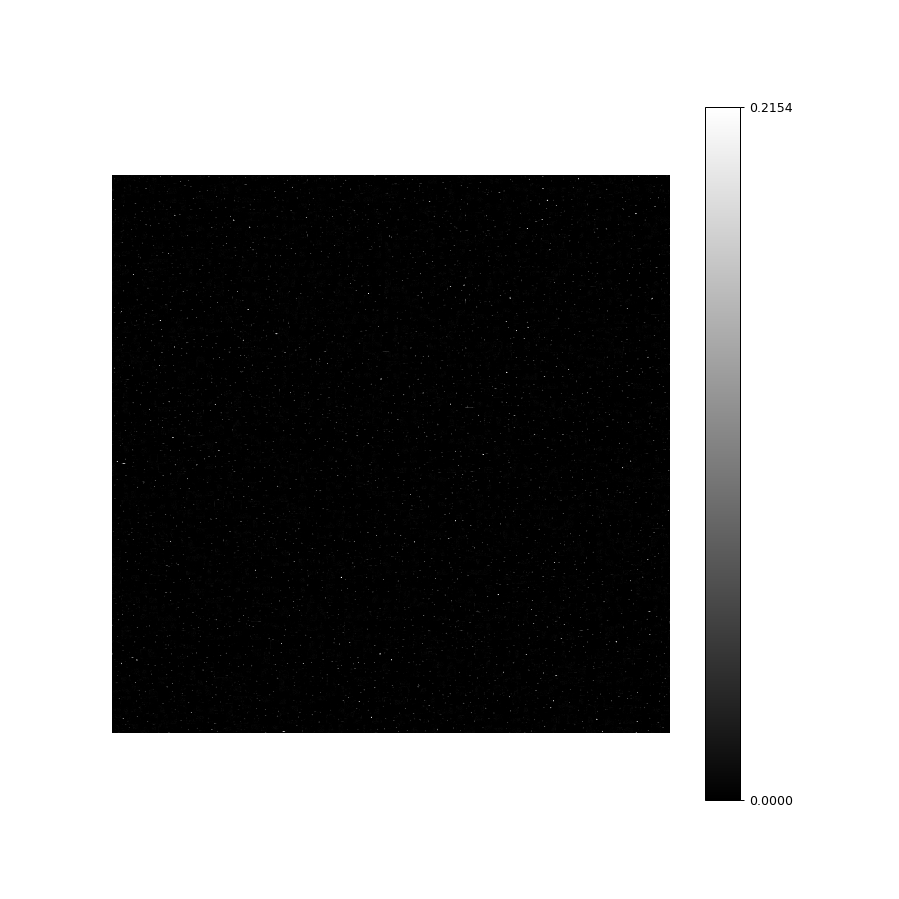

100%|██████████| 50000/50000 [00:52<00:00, 958.94it/s]


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 50000
prec = 1e-10

# Sparse Layer
Kx = 60
Ky = 60
sN = Kx * Ky
m_len = sl ** 2

n_w = 200 #Number of winners

sw = cp.random.uniform(0, 0.01, (sN, m_len))
xi = 0.00005

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


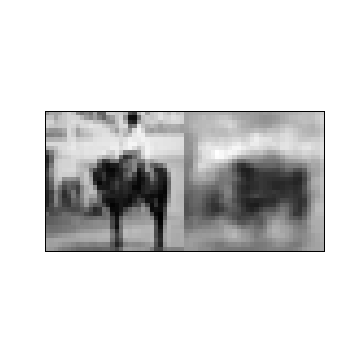

<IPython.core.display.Javascript object>


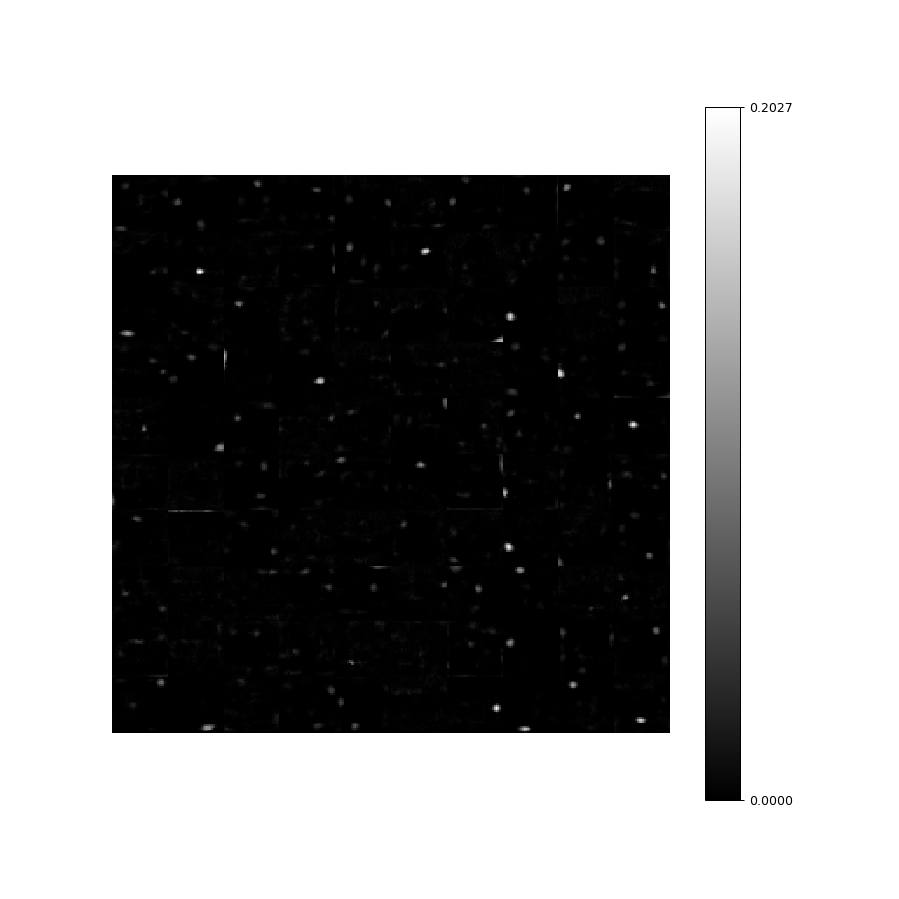

In [41]:
plt.figure(figsize=(4, 4))

img_i = 11

v = gp_gray[img_i].reshape(-1, 1)
p = sw @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p
r = sw.T @ so_uw

vr = np.zeros((32, 64))
vr[:, :32] = v.reshape(32, 32).get()
vr[:, -32:] = r.reshape(32, 32).get()

plt.xticks([])
plt.yticks([])
plt.imshow(vr, cmap="gray")
plt.show()

fig = plt.figure(figsize=(10, 10))

draw_weights(sw[winners].get(), 10, 10, sl, fig)

Yeah, I think at this point I've simply used too many winners.  The network is basically just learning dots at this point, which is really no good.  Ok, I'm going to try one final thing.  I'm going to do 100 winners with a bigger network, and see what it gets.

<IPython.core.display.Javascript object>


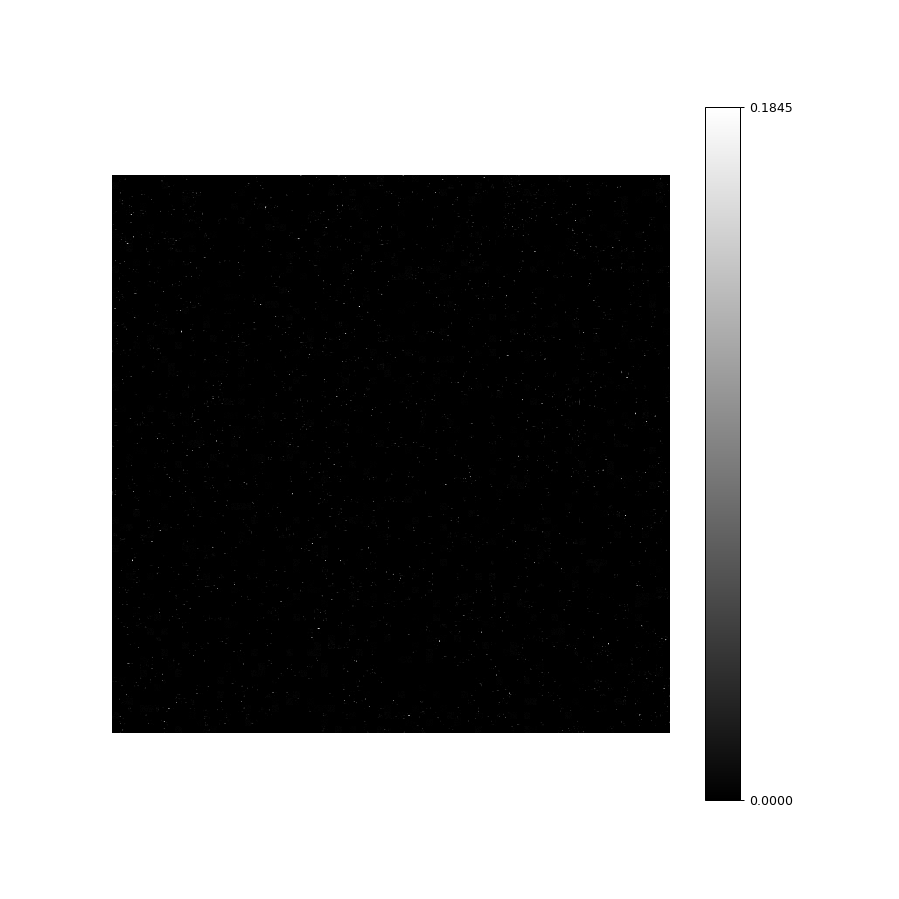

100%|██████████| 50000/50000 [01:06<00:00, 756.68it/s]


In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 5
T_s = 50000
prec = 1e-10

# Sparse Layer
Kx = 80
Ky = 80
sN = Kx * Ky
m_len = sl ** 2

n_w = 100 #Number of winners

sw = cp.random.uniform(0, 0.1, (sN, m_len))
xi = 0.0001

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


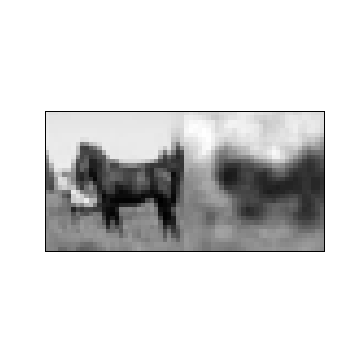

<IPython.core.display.Javascript object>


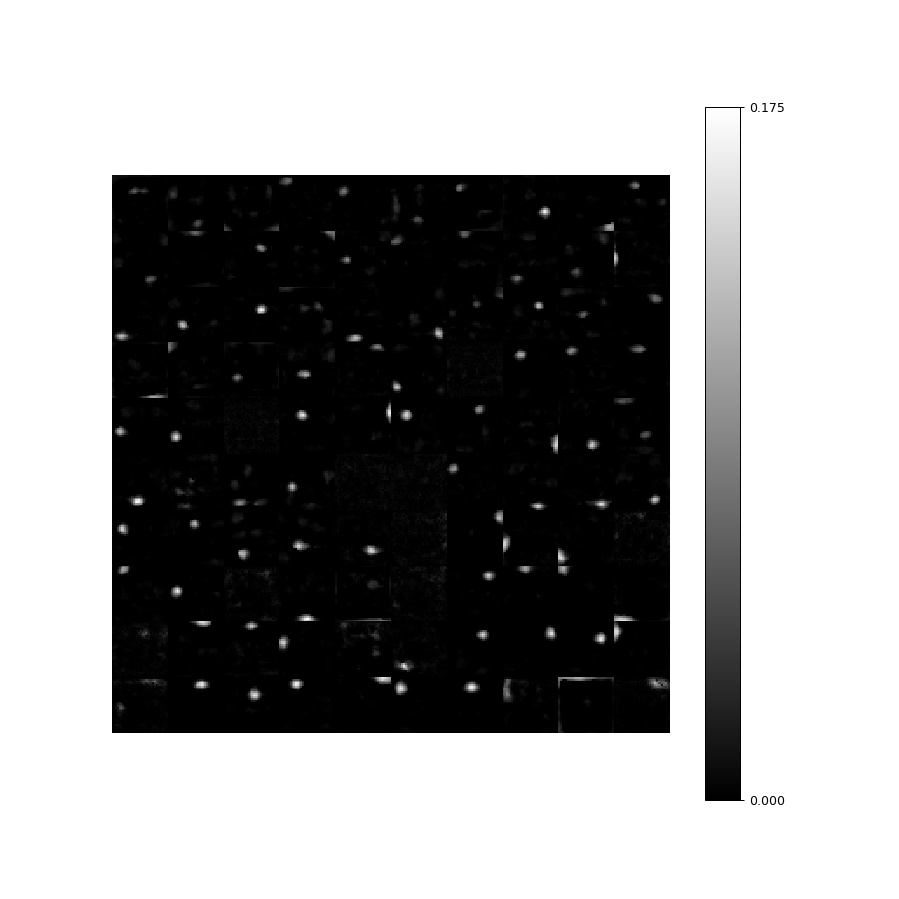

In [13]:
plt.figure(figsize=(4, 4))

img_i = 12

v = gp_gray[img_i].reshape(-1, 1)
p = sw @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p
r = sw.T @ so_uw

vr = np.zeros((32, 64))
vr[:, :32] = v.reshape(32, 32).get()
vr[:, -32:] = r.reshape(32, 32).get()

plt.xticks([])
plt.yticks([])
plt.imshow(vr, cmap="gray")
plt.show()

fig = plt.figure(figsize=(10, 10))

draw_weights(sw[winners].get(), 10, 10, sl, fig)

Hmm.  I'm not a huge fan of the network just learning a bunch of dots. That's not where structure lies.  Ok, I've been running the instance for awhile, so I kinda what to shut it down while I figure out what to do next, but I'm going to do the same number of neurons with 50 winners, and see what kind of structure I get.

<IPython.core.display.Javascript object>


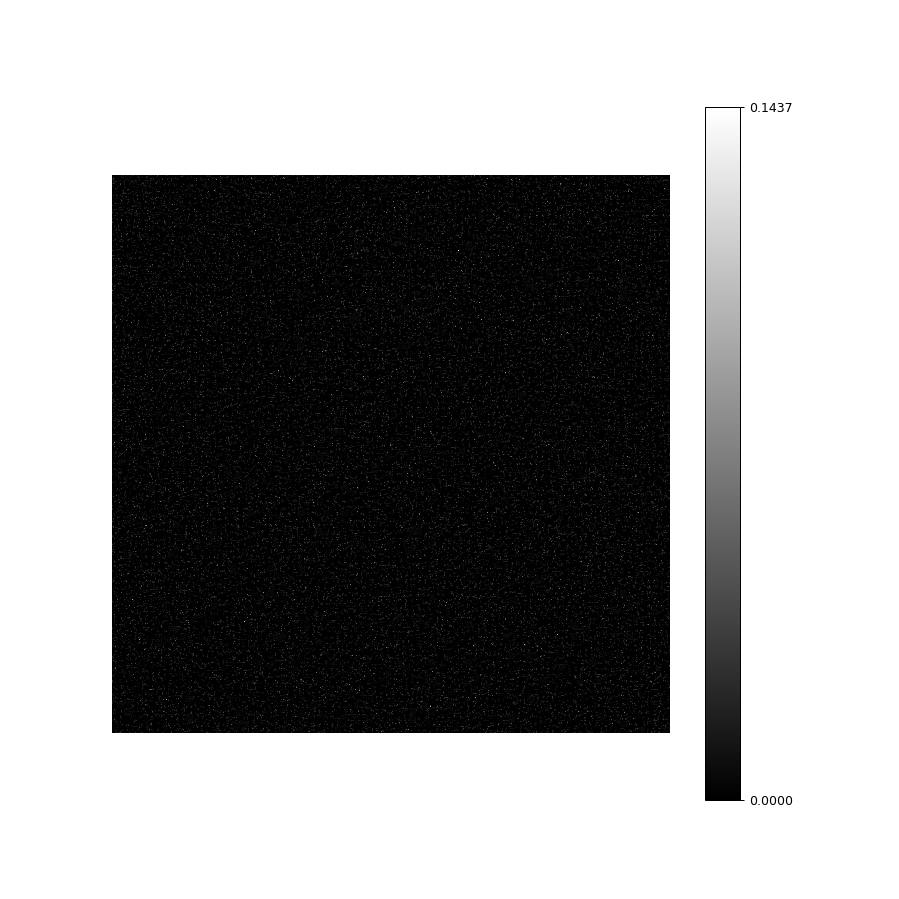

100%|██████████| 50000/50000 [01:17<00:00, 646.49it/s]


In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 3
T_s = 50000
prec = 1e-10

# Sparse Layer
Kx = 90
Ky = 90
sN = Kx * Ky
m_len = sl ** 2

n_w = 50 #Number of winners

sw = cp.random.uniform(0, 0.01, (sN, m_len))
xi = 0.0005

for ep in range(Nep):
    inputs = gp_gray[cp.random.permutation(T_s)] 
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi
        
        sw = cp.clip(sw, 0, 1)

    draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


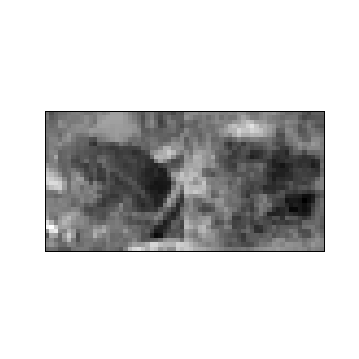

<IPython.core.display.Javascript object>


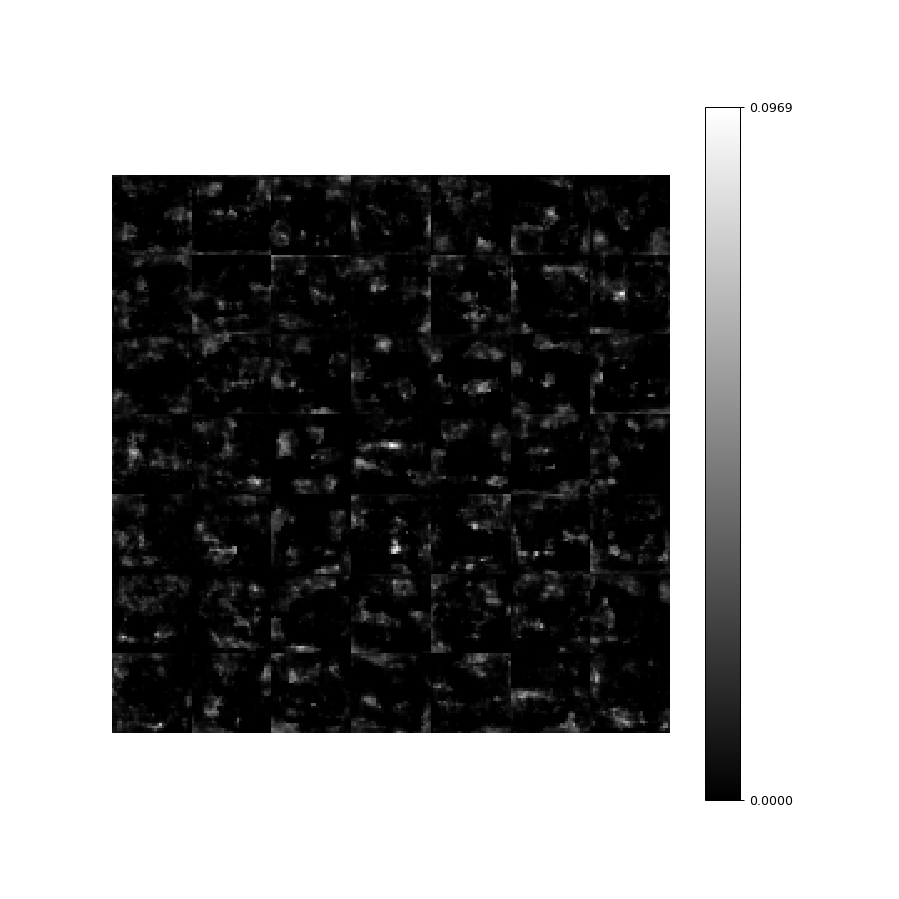

In [28]:
plt.figure(figsize=(4, 4))

img_i = 23

v = gp_gray[img_i].reshape(-1, 1)
p = sw @ v
winners = cp.argsort(p, axis=0)[-n_w:]
mask = cp.zeros((sN, 1))
mask[winners] = 1
so_uw = mask * p
r = sw.T @ so_uw

vr = np.zeros((32, 64))
vr[:, :32] = v.reshape(32, 32).get()
vr[:, -32:] = r.reshape(32, 32).get()

plt.xticks([])
plt.yticks([])
plt.imshow(vr, cmap="gray")
plt.show()

fig = plt.figure(figsize=(10, 10))

draw_weights(sw[winners].get(), 7, 7, sl, fig)

Yikes.  Well, that looks like not enough structure going on in the network.

## Conclusions

I'm all about the network learning spherical harmonics.  That's super dope.  But it seems pretty difficult to get the network to learn interesting stuff.  Suffice it to say we're not exactly seeing Gabor filters.

I really need to figure out what whitening is.  Given how the network behaved with 3,600 neurons and 100 winners, I think we might actually see Gabor-like prototypes if I whiten all the images.

## Next steps

Whiten the images, try again.